## Some imports

In [1]:
%pylab inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import util
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dist(f1, f2):
    """
    distance between two frames assuming they are optimally aligned
    :param f1: frame 1
    :param f2: frame 2
    :return: the distance
    """
    return np.sum (np.power((f1 - f2).reshape((-1, 1)), 2))

In [3]:
f_orig_data = '../149septinpixels.mat'
f_rotated_data = '../149septin_rotated.npy'
f_distances = '../149septin_distances.npy'

## Load, center, rotate, pad and save data

In [4]:
frames_padded = []

if not os.path.isfile(f_rotated_data):
    raw_dat = scipy.io.loadmat(f_orig_data)

    dat = raw_dat["allseptins"]
    lxmax = None
    lymax = None
    n_frames = dat.size
    for i in range(n_frames):
        frame_dat = dat[0][i]
        lx, ly = frame_dat.shape
        lxmax = max(lx, lxmax) if lxmax is not None else lx
        lymax = max(ly, lymax) if lymax is not None else ly

    lmax = max(lxmax, lymax) * 1.5

    for i in range(n_frames):
        frame_dat = dat[0][i]

        lx, ly = frame_dat.shape
        cx, cy = util.frame_COM(frame_dat)

        offset_x = int(np.rint(0.5 * lx - cx))
        offset_y = int(np.rint(0.5 * ly - cy))

        frame_dat = np.roll(frame_dat, offset_x, axis=0)
        frame_dat = np.roll(frame_dat, offset_y, axis=1)

        th = util.frame_orient(frame_dat)

        frame_dat_padded = np.zeros([lmax, lmax], dtype=np.float32)
        util.insert_rot_frame(frame_dat, frame_dat_padded, th)
        frames_padded.append(frame_dat_padded)

    np.save(f_rotated_data, frames_padded)
else:
    frames_padded = np.load(f_rotated_data)
    n_frames = frames_padded.shape[0]
    print n_frames, "rotated frames loaded!"

if not os.path.isfile(f_distances):
    d = np.zeros((n_frames, n_frames), dtype=np.float32)
    for i in range(n_frames):
        for j in range(i + 1, n_frames):
            d[i, j] = dist(frames_padded[i], frames_padded[j])
            d[j, i] = d[i, j]
    np.save(f_distances, d)
else:
    d = np.load(f_distances)
    
print frames_padded.shape
frames_padded = frames_padded.reshape(149, -1)

149 rotated frames loaded!
(149, 372, 372)


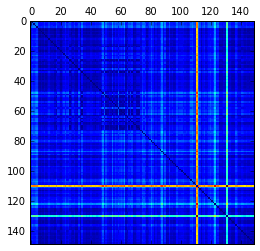

In [5]:
matshow(d)

In [6]:
print d.shape

(149, 149)


In [7]:
Gamma = 10.0
n_components = 2

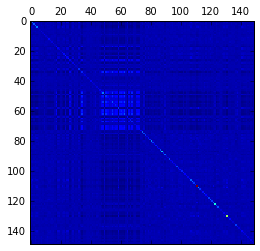

In [8]:
K = np.exp ( -Gamma * d)
one_n = np.ones((n_frames,n_frames)) / float (n_frames)

K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

matshow(K)

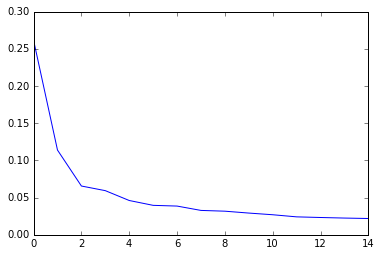

In [9]:
eig_vals, eig_vecs = np.linalg.eigh (K)

X_pc = np.column_stack((eig_vecs[:,-i] for i in range (1, n_components + 1)))

plot(range(len(eig_vals))[:15], sorted(eig_vals, reverse=True)[:15])

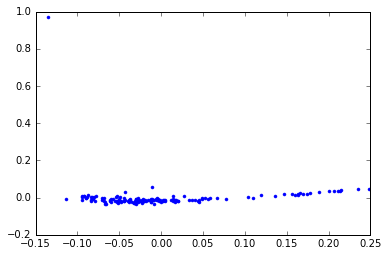

In [10]:
plot (X_pc[:, 0], X_pc[:, 1], marker='.', linewidth = 0)

In [11]:
# unique!
frames_padded_sums = [sum(x) for x in frames_padded]
def metric(X, Y):
    xi = np.where(frames_padded_sums==sum(X))[0]
    yi = np.where(frames_padded_sums==sum(Y))[0]
    
    return K[xi, yi]

In [12]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='precomputed', gamma=10)
pca.kernel = metric
res = pca.fit_transform(frames_padded)

In [13]:
# todo: apply http://sebastianraschka.com/Articles/2014_kernel_pca.html 
# or http://www.stat.washington.edu/courses/stat539/spring14/Resources/tutorial_nonlin-dim-red.pdf

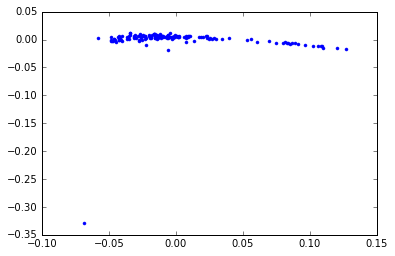

In [14]:
plot(res[:,0], res[:,1], marker='.', linewidth=0)

In [15]:
lst = np.empty((n_frames, 2))
for i in range (n_frames):
    x = pca.transform(frames_padded[i].reshape(1,-1))[0][0]
    lst[i, :] = np.array([i, x])
idx = np.argsort(lst[:,1])


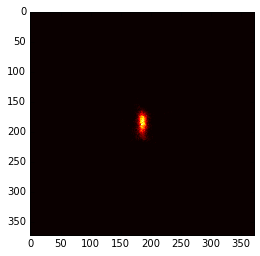

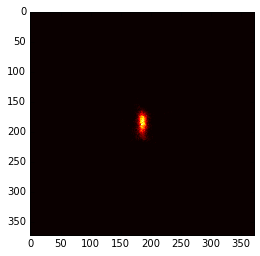

In [16]:
import pylab as pl
import time
from IPython import display

for j in range (n_frames):
    plt.imshow (frames_padded[idx[j]].reshape(372, 372), cmap = plt.get_cmap('hot'))

    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.1)


In [17]:

print frames_padded.shape

#pca.transform(frames_padded)

(149, 138384)


In [18]:
res[:2] - pca.transform(frames_padded[:2])

array([[ -1.38777878e-17,  -3.46944695e-18],
       [ -1.52655666e-16,  -1.73472348e-17]])